In [1]:
import os
import time
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timm

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models

from sklearn.model_selection import StratifiedKFold


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
#导入并查看数据
data_dir = '../dataset/'
samples_dir = data_dir + 'train.csv'
test_samples_dir = data_dir + 'test.csv'

df = pd.read_csv(samples_dir)
print(df.head())
df.describe()

          image             label
0  images/0.jpg  maclura_pomifera
1  images/1.jpg  maclura_pomifera
2  images/2.jpg  maclura_pomifera
3  images/3.jpg  maclura_pomifera
4  images/4.jpg  maclura_pomifera


,image,label
count,18353,18353
unique,18353,176
top,images/0.jpg,maclura_pomifera
freq,1,353


In [4]:
image0 = plt.imread(os.path.join(data_dir, 'images/0.jpg'))
image0.shape

(224, 224, 3)

In [5]:
#建立标签和索引的对应关系
labels = df['label']
labels = labels.unique()
labels.sort()
labels_idx = {label: i for i, label in enumerate(labels)}
print(len(labels_idx))
print(labels)
print(labels_idx)

176
['abies_concolor' 'abies_nordmanniana' 'acer_campestre' 'acer_ginnala'
 'acer_griseum' 'acer_negundo' 'acer_palmatum' 'acer_pensylvanicum'
 'acer_platanoides' 'acer_pseudoplatanus' 'acer_rubrum' 'acer_saccharinum'
 'acer_saccharum' 'aesculus_flava' 'aesculus_glabra'
 'aesculus_hippocastamon' 'aesculus_pavi' 'ailanthus_altissima'
 'albizia_julibrissin' 'amelanchier_arborea' 'amelanchier_canadensis'
 'amelanchier_laevis' 'asimina_triloba' 'betula_alleghaniensis'
 'betula_jacqemontii' 'betula_lenta' 'betula_nigra' 'betula_populifolia'
 'broussonettia_papyrifera' 'carpinus_betulus' 'carpinus_caroliniana'
 'carya_cordiformis' 'carya_glabra' 'carya_ovata' 'carya_tomentosa'
 'castanea_dentata' 'catalpa_bignonioides' 'catalpa_speciosa'
 'cedrus_atlantica' 'cedrus_deodara' 'cedrus_libani' 'celtis_occidentalis'
 'celtis_tenuifolia' 'cercidiphyllum_japonicum' 'cercis_canadensis'
 'chamaecyparis_pisifera' 'chamaecyparis_thyoides' 'chionanthus_retusus'
 'chionanthus_virginicus' 'cladrastis_lute

In [6]:
#设置参数
params = {
    'lr': 0.001,
    'batch_size': 64,
    'num_epochs': 40,
    'k_fold': 5,
    'num_classes': 176,
    'model_save_path': '../model/',
    'pre_train_model_path':'../pre_train_model/seresnext50_32x4d_racm-a304a460.pth',
    'model_name': 'seresnext50_32x4d',
    'num_workers': 4,
}

In [7]:
#定义数据集
class LeavesDataset(Dataset):
    def __init__(self, image_dirs,labels, transform=None):
        self.image_dirs = image_dirs
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_dirs)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(data_dir, self.image_dirs[idx]))
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
            image = torch.clamp(image, 0, 1)
        return image, labels_idx[label]
    

#数据转换
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),#缩放到224*224
    transforms.RandomHorizontalFlip(),#随机水平翻转
    transforms.RandomVerticalFlip(),#随机垂直翻转
    transforms.RandomRotation(90),#随机旋转
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1,hue=0.1),#随机改变亮度、对比度、饱和度和色调
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),#标准化
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),#标准化
])


In [8]:
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [9]:
class LeafClassifier(nn.Module):
    def __init__(self, out_features=params['num_classes']):
        super().__init__()
        pretrained_cfg = timm.models.create_model(params['model_name']).default_cfg
        pretrained_cfg['file'] = params['pre_train_model_path']
        self.model = timm.create_model(params['model_name'], pretrained=True, pretrained_cfg=pretrained_cfg)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, out_features)

    def forward(self, x):
        x = self.model(x)
        return x

In [10]:
def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) == y).float().mean().item()

In [11]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    '''
    train_loader: 训练数据集
    model: 模型
    criterion: 损失函数
    optimizer: 优化器
    epoch: 当前轮数
    params: 参数
    '''
    metric = Accumulator(2)#记录损失和准确率
    model.train()
    n = len(train_loader)
    for i, (images, labels) in enumerate(train_loader):
        print('\r', 'training progress: %d/%d' % (i+1, n), end='')
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        metric.add(loss.item() , accuracy(outputs, labels))
    print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch+1, params['num_epochs'], metric[0]/n, metric[1]/n))
    return metric[0]/n, metric[1]/n

def validate(valid_loader, model, criterion, epoch, params):
    '''
    valid_loader: 验证数据集
    model: 模型
    criterion: 损失函数
    epoch: 当前轮数
    params: 参数
    '''
    metric = Accumulator(2)#记录损失和准确率
    model.eval()
    n = len(valid_loader)
    with torch.no_grad():
        for i, (images, labels) in enumerate(valid_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            metric.add(loss.item() , accuracy(outputs, labels))
    print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch+1, params['num_epochs'], metric[0]/n, metric[1]/n))
    return metric[0]/n, metric[1]/n

In [12]:
def show_loss_acc(train_loss, train_acc, valid_loss, valid_acc):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='train_loss')
    plt.plot(valid_loss, label='valid_loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='train_acc')
    plt.plot(valid_acc, label='valid_acc')
    plt.legend()
    plt.show()

In [19]:
#使用交叉验证法
kf = StratifiedKFold(n_splits=params['k_fold'], shuffle=True, random_state=2023)

for k, (train_index, test_index) in enumerate(kf.split(df['image'], df['label'])):
    
    train_img,valid_img = df['image'].iloc[train_index],df['image'].iloc[test_index]
    train_label,valid_label = df['label'][train_index],df['label'].iloc[test_index]

    train_img_dirs = [os.path.join(data_dir, path) for path in train_img]
    valid_img_dirs = [os.path.join(data_dir, path) for path in valid_img]
    
    train_dataset = LeavesDataset(train_img_dirs, train_label.values, transform=train_transform)
    valid_dataset = LeavesDataset(valid_img_dirs, valid_label.values, transform=valid_transform)

    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, num_workers=params['num_workers'])
    valid_loader = DataLoader(valid_dataset, batch_size=params['batch_size'], shuffle=False, num_workers=params['num_workers'])

    model = LeafClassifier().to(device)
    model = nn.DataParallel(model)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    

    print("Start training fold {}...".format(k))
    metrics = []
    for epoch in range(params['num_epochs']):
        metric = Accumulator(4)#记录损失和准确率
        train_loss, train_acc = train(train_loader, model, criterion, optimizer, epoch, params)
        valid_loss, valid_acc = validate(valid_loader, model, criterion, epoch, params)
        metric.add(train_loss, train_acc, valid_loss, valid_acc)
        metrics.append(metric.data)
        torch.save(model.state_dict(), params['model_save_path'] + str(k)+"fold_"+str(epoch)+"epoch" + '.pth')
    train_loss, train_acc, valid_loss, valid_acc = zip(*metrics)
    show_loss_acc(train_loss, train_acc, valid_loss, valid_acc)

    


Start training fold 0...


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/chenyuhan/anaconda3/envs/ml_torch/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/chenyuhan/anaconda3/envs/ml_torch/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'LeavesDataset' on <module '__main__' (built-in)>


KeyboardInterrupt: 

14682
../dataset/images/0.jpg
2
3


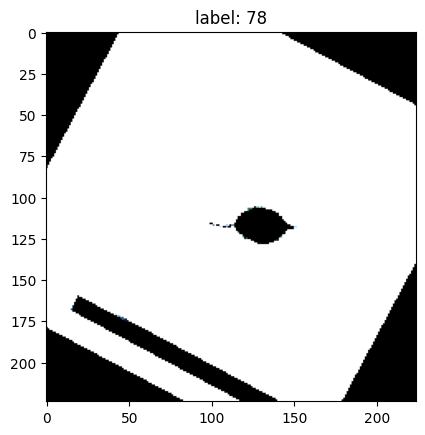

../dataset/images/1.jpg
2
3


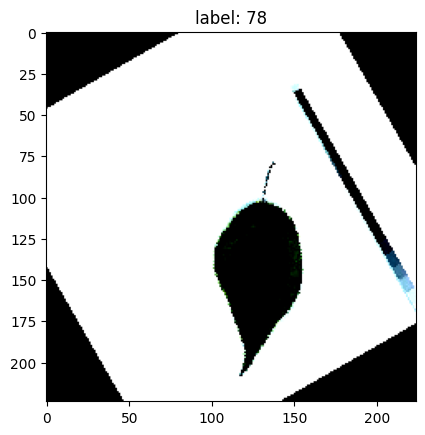

../dataset/images/2.jpg
2
3


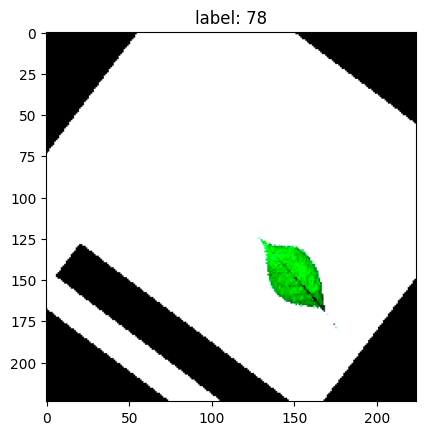

../dataset/images/3.jpg
2
3


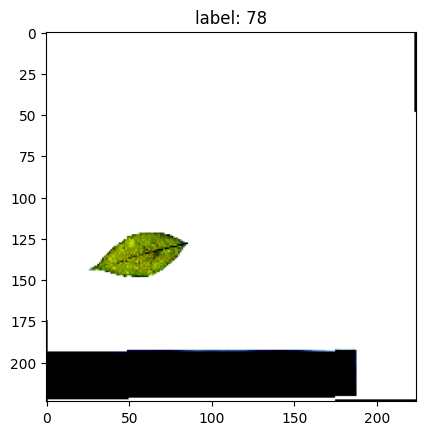

../dataset/images/4.jpg
2
3


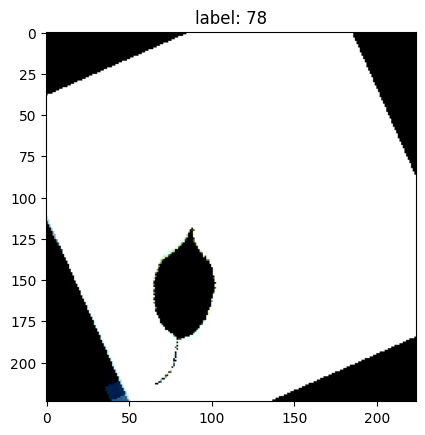

../dataset/images/5.jpg
2
3


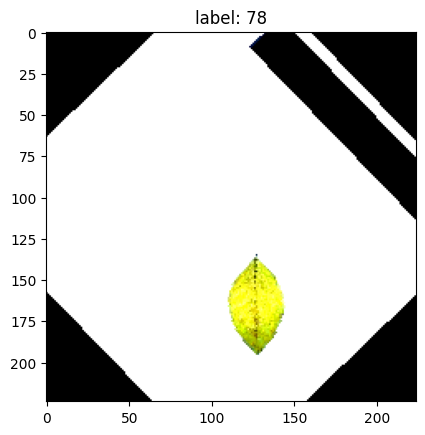

../dataset/images/6.jpg
2
3


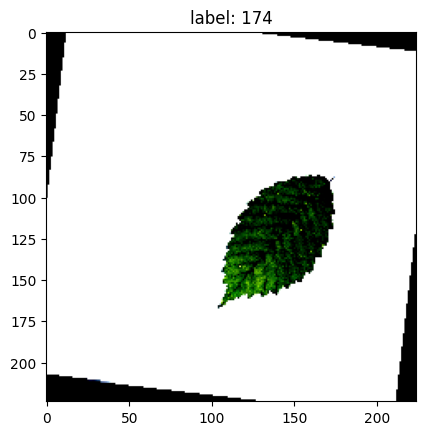

../dataset/images/7.jpg
2
3


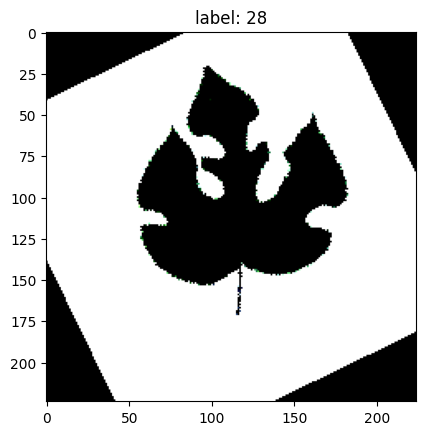

../dataset/images/8.jpg
2
3


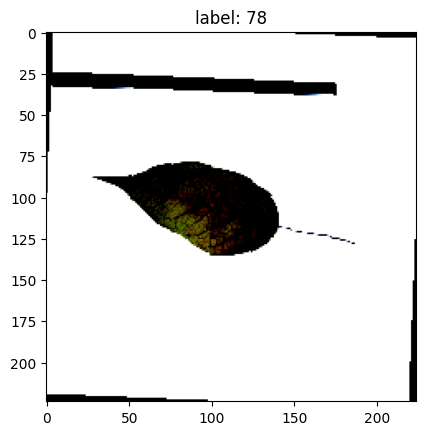

../dataset/images/9.jpg
2
3


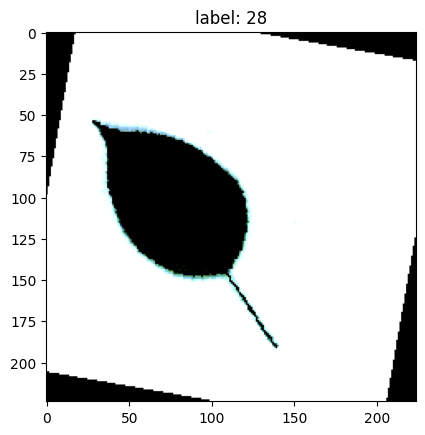

KeyError: 10

In [ ]:
print(len(train_dataset))
for i, (image, label) in enumerate(train_dataset):
    print(train_dataset.image_dirs[i])  
    plt.title('label: {}'.format(label))
    print(2)
    plt.imshow(image.permute(1, 2, 0))
    print(3)
    plt.show()


In [ ]:
#测试集
def TestDataset(Dataset):
    def __init__(self, samples_dir, transform=None):
        self.samples = pd.read_csv(samples_dir)
        self.image_paths = self.samples.iloc[:, 0]
        self.transform = transform  

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image = plt.imread(os.path.join(data_dir, self.image_paths[idx]))
        if self.transform:
            image = self.transform(image)
        return image
    

#测试模型
def load_model(model_path):
    model = LeafClassifier().to(device)
    model.load_state_dict(torch.load(model_path))
    return model

def predict(models, test_loader):
    preds = []
    for model in models:
        model.eval()
        with torch.no_grad():
            for images, _ in test_loader:
                images = images.to(device)
                outputs = model(images)
                preds.append(outputs)
    preds = torch.stack(preds).mean(0).argmax(1)
    return preds

test_df = pd.read_csv(test_samples_dir)
test_dataset = TestDataset(test_samples_dir, transform=valid_transform)
test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)

models = []
for i in range(params['k_fold']):
    model = load_model(params['model_save_path'] + 'model_{}.pth'.format(i+1))
    models.append(model)

preds = predict(models, test_loader)
preds = [labels[i] for i in preds]
test_df['label'] = preds
test_df.to_csv(data_dir + 'submission.csv', index=False)
